In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
from read_hdf5 import read_hdf5_convolution

In [2]:
NBINS = 8
NFG = [6] * NBINS

### Load data

['ant_temp', 'freq', 'lst']


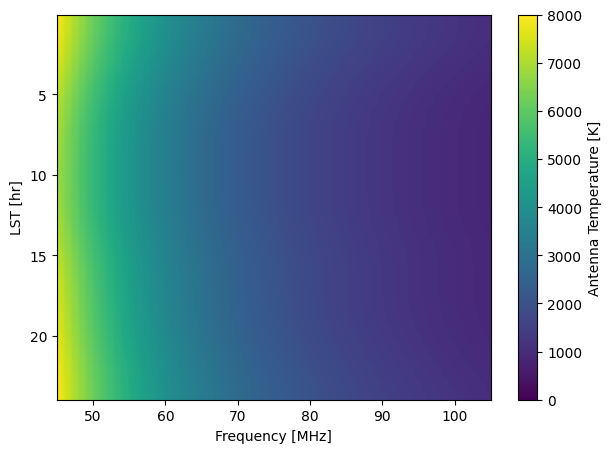

In [3]:
lst, freq, temp = read_hdf5_convolution(
    "simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

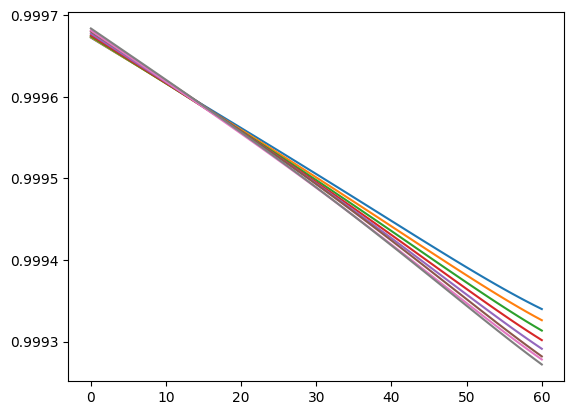

In [4]:
fg_bin = temp[:-(nspec%NBINS)].reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Foreground model

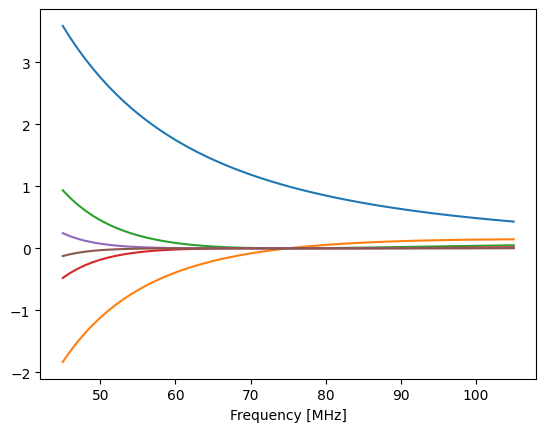

In [5]:
def design_mat(freq, nfg=5, beta=-2.5, nu_fg=75):
    """
    Generate a matrix of shape (Nfreq, Nfg) that evaluates the linlog model given a vector of foreground parameters.

    Parameters
    ----------
    freq : np.ndarray
        Frequencies to evaluate the model at.
    nfg : int
        Number of foreground terms.
    beta : float
        Spectral index of power law.
    nu_fg : float
        Normalization frequency in same units as freq.

    Returns
    -------
    A : np.ndarray
        The design matrix, i.e., a matrix with the linlog basis functions as the columns.
    
    """
    f_ratio = freq[:, None]/nu_fg  # dimensionless frequency ratio
    powers = np.arange(nfg)[None]
    A = f_ratio**beta * np.log(f_ratio)**powers
    return A

nfg_max = np.max(NFG)
A_max = design_mat(freq, nfg=nfg_max)

plt.figure()
for i in range(nfg_max):
    plt.plot(freq, A_max[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

In [6]:
class LSTBin:
    def __init__(self, freq, spec, noise_std, nfg):
        """
        Class for a LST bin, holding a spectrum, noise, design matrix and necessary covariance matrices.

        Parameters
        -----------
        freq : np.ndarray
            The frequency array corresponding to the spectrum.
        spec : np.ndarray
            The spectrum at the given LST bin.
        noise_std : np.ndarray
            The standard deviation of the noise to inject at each frequency channel.
        nfg : int
            Number of foreground parameters to fit.
        
        """
        self.freq = freq
        self.spec = spec.copy()
        self.nfg = nfg
        self.A = design_mat(self.freq, nfg=self.nfg)
        self.noise_std = noise_std
        self._noise_added = False
        self.add_noise()
        self.compute_covs()
         
    def add_noise(self):
        if self._noise_added:
            return
        noise = rng.normal(scale=self.noise_std)
        self.spec += noise
        self._noise_added = True

    def compute_covs(self):
        """Compute necessary covariance matrices"""
        if not self._noise_added:
            self.add_noise()
        self.sigma = np.diag(self.noise_std**2)
        self.sigma_inv = np.diag(1/self.noise_std**2)
        Cinv = self.A.T @ self.sigma_inv @ self.A
        self.C = np.linalg.inv(Cinv)
        self.sigma_fg = self.A @ self.C @ self.A.T
        V = np.linalg.inv(np.linalg.inv(self.sigma_fg) - self.sigma_inv)
        self.C_total_inv = np.linalg.inv(self.sigma + V)
        

def fg_mle(lst_bin, true_t21, model_t21):
    """
    Compute MLE foreground parameters given an instance of TimeBin, an injected (true) 21cm signal and a model 21cm signal.

    Parameters
    ----------
    lst_bin : LSTBin
        One foreground spectrum from a given LST bin.
    true_t21 : np.ndarray
        The injected 21cm signal.
    model_t21 : np.ndarray
        The assumed model of the 21cm signal.

    Returns
    -------
    theta_hat : np.ndarray
        The MLE foreground parameters.
    dstar : np.ndarray
        The residual spectrum after subtracting the 21cm model and best-fit foregrounds from the total
        time_bin + injected 21cm spectrum.
    
    """
    d = lst_bin.spec + true_t21
    r = d - model_t21
    theta_hat = lst_bin.C @ lst_bin.A.T @ lst_bin.sigma_inv @ r
    dstar = r - lst_bin.A @ theta_hat  # eq 8 in Monsalve 2018
    return theta_hat, dstar

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [7]:
rng = np.random.default_rng(seed=1913)  # initialize random number generator
noise_75 = 3e-3
noise_std = noise_75 * (fg_bin/fg_mean[freq==75]) * np.sqrt(nspec/(nspec//NBINS))  # radiometer equation
noise_mean_std = noise_75 * (fg_mean/fg_mean[freq==75])

### Global signal

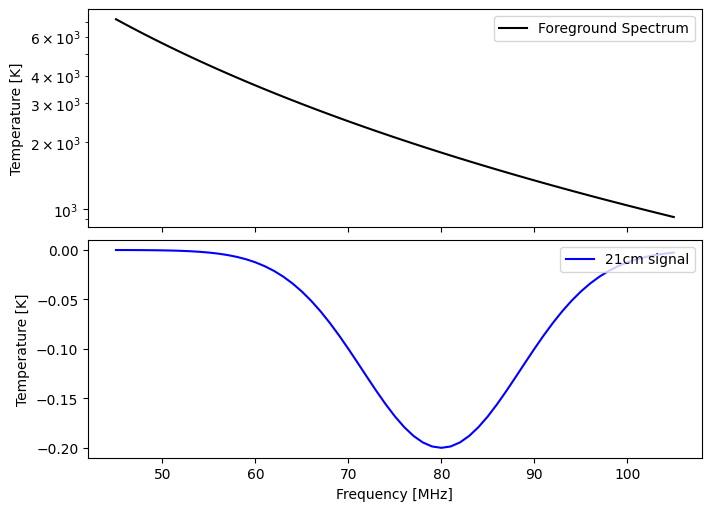

In [8]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_T21 = gauss(freq)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Initialize and run sampler

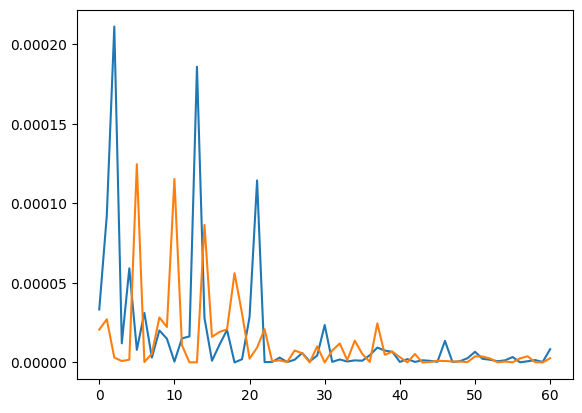

In [22]:
lst_bins = [LSTBin(freq, fg_bin[i], noise_std[i]/np.sqrt(NBINS), NFG[i]) for i in range(NBINS)]
lst24h = LSTBin(freq, fg_mean, noise_mean_std, 6)
#lst_bins = [LSTBin(freq, fg_bin[i], noise_mean_std, NFG[i]) for i in range(NBINS)]

r_mean = fg_mle(lst24h, 0, 0)[1]
r_bin = fg_mle(lst_bins[0], 0, 0)[1]
plt.figure()
plt.plot(r_mean**2)
plt.plot(r_bin**2)
plt.show()

In [23]:
def log_prior(params, bounds):
    """
    Uniform priors on all parameters.
    """
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0

# Parameter bounds (a, w, nu21)
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
n_dim = len(bounds)

def _log_likelihood_1spec(params, lst_bin):
    """
    The log likelihood for one spectrum.
    """
    t21_model = gauss(freq, *params)
    dstar = fg_mle(lst_bin, TRUE_T21, t21_model)[1]
    return -1/2 * dstar.T @ lst_bin.C_total_inv @ dstar

def log_likelihood(params, lst_bins):
    if isinstance(lst_bins, LSTBin):  # 1 bin only, not a list
        return _log_likelihood_1spec(params, lst_bins)
    lnL = 0
    for lst_bin in lst_bins:
        lnL += _log_likelihood_1spec(params, lst_bin)
    return lnL
    

n_particles = 1000
prior_samples = rng.uniform(size=(n_particles, n_dim), low=bounds.T[0], high=bounds.T[1])

In [ ]:
log_like_args = [lst_bins]
#log_like_args = [lst_bins[0]]
#log_like_args = [lst24h]

sampler = pc.Sampler(
    n_particles,
    n_dim,
    log_likelihood,
    log_prior,
    vectorize_likelihood=True,
    bounds=bounds,
    log_likelihood_args=log_like_args,
    log_prior_args=[bounds],
)
sampler.run(prior_samples)
results = sampler.results

Iter: 9it [00:18,  2.29s/it, beta=0.000309, calls=23000, ESS=0.95, logZ=-3.06, accept=0.188, N=3, scale=0.935, corr=0.726]

In [ ]:
pc.plotting.corner(results, labels=['a', 'w', r'$\nu_{21}$']);